<a href="https://colab.research.google.com/github/abubakarsidiq14/Stock_Predicrion_LSTM_Time-_Series/blob/main/Stock_Predicrion_LSTM_Time__Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install yfinance

In [1]:
import  yfinance as yf

In [2]:
sp500 = yf.Ticker("^GSPC")

In [3]:
sp500 = sp500.history(period="max")

In [4]:
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


#### Data Visuliazation

<Axes: xlabel='Date'>

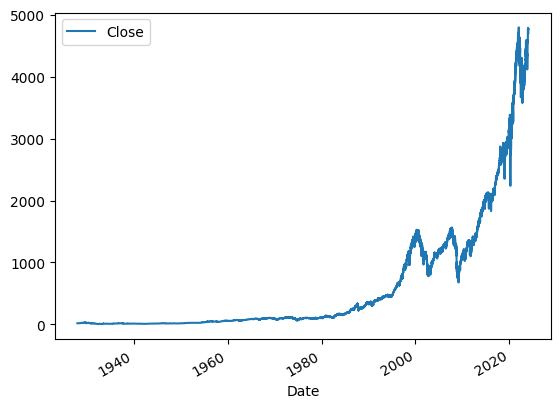

In [5]:
sp500.plot.line(y="Close",use_index=True)

#### Data Cleaning

In [6]:
del sp500["Dividends"]

In [7]:
del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [13]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000


In [9]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [10]:
sp500 = sp500.loc["1950-01-01":].copy()

In [11]:
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1950-01-03 00:00:00-05:00,16.66,16.66,16.66,16.66,1260000,16.850000,1
1950-01-04 00:00:00-05:00,16.85,16.85,16.85,16.85,1890000,16.930000,1
1950-01-05 00:00:00-05:00,16.93,16.93,16.93,16.93,2550000,16.980000,1
1950-01-06 00:00:00-05:00,16.98,16.98,16.98,16.98,2010000,17.080000,1
1950-01-09 00:00:00-05:00,17.08,17.08,17.08,17.08,2520000,17.030001,0


#### Model Training

In [12]:
from sklearn.ensemble import RandomForestClassifier as rfc
model = rfc(n_estimators=100, min_samples_split=100, random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [13]:
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])

In [14]:
import pandas as pd
preds = pd.Series(preds, index=test.index)

In [15]:
preds.value_counts()

0    52
1    48
dtype: int64

In [16]:
precision_score(test["Target"], preds)

0.5208333333333334

<Axes: xlabel='Date'>

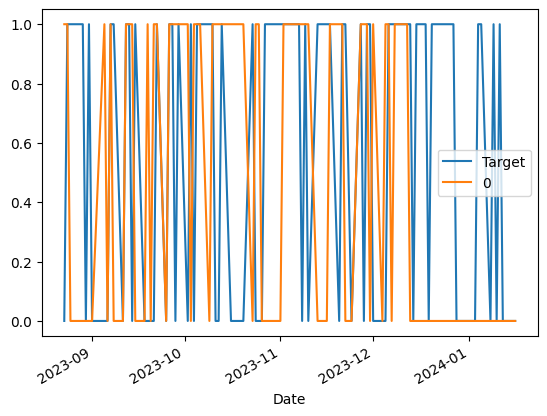

In [17]:
combine = pd.concat([test["Target"], preds], axis=1)
combine.plot()

In [18]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [19]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []
  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict (train, test, predictors, model)
    all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [20]:
predicitions = backtest(sp500, model, predictors)

In [21]:
predicitions["Predictions"].value_counts()

1    198
0     52
Name: Predictions, dtype: int64

In [22]:
precision_score(predicitions["Target"], predicitions["Predictions"])

0.5

#### Improve Model

In [23]:
horizons = [2,5,60,250,1000]
new_predictors = []
for horizon in horizons:
  rolling_averages = sp500.rolling(horizon).mean()
  ratio_column = f"Close_Ratio_{horizon}"
  sp500 [ratio_column] = sp500["Close"] / rolling_averages ["Close"]
  trend_column = f"Trend_{horizon}"
  sp500 [trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
  new_predictors+=[ratio_column, trend_column]

In [24]:
sp500.dropna()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1954-01-05 00:00:00-05:00,25.100000,25.100000,25.100000,25.100000,1520000,25.139999,1,1.002997,2.0,1.010711,4.0,1.024490,37.0,1.016073,128.0,1.115463,533.0
1954-01-06 00:00:00-05:00,25.139999,25.139999,25.139999,25.139999,1460000,25.059999,0,1.000796,2.0,1.007534,5.0,1.024902,38.0,1.017895,129.0,1.116829,533.0
1954-01-07 00:00:00-05:00,25.059999,25.059999,25.059999,25.059999,1540000,24.930000,0,0.998406,1.0,1.001919,4.0,1.020615,37.0,1.014864,129.0,1.112873,532.0
1954-01-08 00:00:00-05:00,24.930000,24.930000,24.930000,24.930000,1260000,24.799999,0,0.997399,0.0,0.995766,3.0,1.014418,36.0,1.009788,129.0,1.106709,531.0
1954-01-11 00:00:00-05:00,24.799999,24.799999,24.799999,24.799999,1220000,24.930000,1,0.997386,0.0,0.991762,2.0,1.008349,35.0,1.004694,129.0,1.100561,530.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08 00:00:00-05:00,4703.700195,4764.540039,4699.819824,4763.540039,3742320000,4756.500000,0,1.007008,2.0,1.009349,2.0,1.056736,36.0,1.107535,137.0,1.197375,528.0
2024-01-09 00:00:00-05:00,4741.930176,4765.470215,4730.350098,4756.500000,3529960000,4783.450195,1,0.999261,1.0,1.007273,2.0,1.053589,36.0,1.105038,136.0,1.195176,527.0
2024-01-10 00:00:00-05:00,4759.939941,4790.799805,4756.200195,4783.450195,3498680000,4780.240234,0,1.002825,1.0,1.009618,3.0,1.057780,37.0,1.110459,136.0,1.201507,528.0


In [25]:
model = rfc(n_estimators=200, min_samples_split=50, random_state=1)

In [26]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["Target"])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .6] = 1
  preds[preds < .6] = 0
  preds = pd.Series (preds, index=test.index, name="Predictions")
  combined = pd.concat([test["Target"], preds], axis=1)
  return combined

In [28]:
print(sp500.isnull().sum())

Open                   0
High                   0
Low                    0
Close                  0
Volume                 0
Tomorrow               1
Target                 0
Close_Ratio_2          1
Trend_2                2
Close_Ratio_5          4
Trend_5                5
Close_Ratio_60        59
Trend_60              60
Close_Ratio_250      249
Trend_250            250
Close_Ratio_1000     999
Trend_1000          1000
dtype: int64


In [30]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
sp500_imputed = pd.DataFrame(imputer.fit_transform(sp500), columns=sp500.columns)

In [32]:
predictions = backtest(sp500_imputed, model, new_predictors)

In [33]:
predictions["Predictions"].value_counts()

0.0    185
1.0     65
Name: Predictions, dtype: int64

In [34]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6461538461538462